<font size="7"> Experiment Scratch Paper

This is where I create the code inside of the `.py` files for each students experiments

# <font color='gray'>Helper Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Create stim patterns

In [5]:
def insert_square_wave_advanced(sig,time,phase_length=20, amplitude=1):
    '''Deflects positively at *time* for 20 samples (1ms) then deflects negatively for 20 samples, 
    then returns to normal'''
    sig[time:time+phase_length] = amplitude
    sig[time+phase_length:time+phase_length*2] = -amplitude
    return sig


def create_stim_pulse_sequence(stim_list, freq_Hz=None, time_arr = None,max_time_s = 1):
    """
    Creates a stim pulse sequence, parallels the real code that will run on the Maxwell
    
    Params:
    stim_list - list of tuples indicating the commands to run
            ------------------------------------------------
            For 'stim' command:
            ('stim', [neuron inds], mv, us per phase)

            For 'delay'
            ('delay', frames_delay)
            
            For 'next'
            ('next', None)
            This command acts as a placeholder to move to the next timepoint in the time_arr or the next
            period triggered by the freq_Hz
            -------------------------------------------------
    freq_Hz - frequency to call the top stim_list in
            *Note* this takes priority over time_arr
    time_arr - array of time values that will be when the stimulations occur in order
    
    max_time_s - time in seconds to stimulate
    
    
    Returns:
    sig - np.array -- shape=(n_neurons, timesteps) of what the signal will look like
    t - np.array   -- shape=(timesteps) of time in seconds
    """
    
    # Since this is fake, only parallels the code on the device,
    # We have to make our own time
    # And simulate what the stimulation will look like
    
    # Conversion paramerters
    fs_ms = 20 # Good for converting frames to ms
    fs_us = .2
    
    # stim list
    seq = ('next',None)
    stim_list.append(seq)
    stim_list=stim_list*freq_Hz
    
    # Setup
    fs = 20000
    n_neurons = 3
    t = np.arange(0,fs*max_time_s)/fs
    sig = np.zeros(shape=(n_neurons,t.shape[0]))
    
    
    # This would be generated in *real time*
    if freq_Hz is not None:
        # Until the time is right to stimulation the sequence
        for time in t[::fs//freq_Hz]:
            time_frames = int(time*fs)
            
            
            if len(stim_list) == 0:
                return sig
            
            #Build the sequence
            command = None
            
            while (command != 'next'):
                command, *params = stim_list.pop(0) # Get first thing off list
                if command == 'stim':
                    neurons, amplitude, phase_length = params
                    phase_length = int(phase_length*fs_us)
                    
                    # Change signal for each neuron
                    for n in neurons:
                        sig[n,:] = insert_square_wave_advanced(sig[n,:],time_frames,phase_length, amplitude=amplitude)
                    time_frames += phase_length*2
                    
                if command == 'delay':
                    time_frames += fs_ms*params[0]
                    
                #double checking here
                if command == 'next':
                    break 
                    
        return sig,t


## Create Plots

In [ ]:
def plotStimPattern(signal,t):
    plt.plot(t,signal.T)
    plt.legend(['n0','n1','n2'])
    plt.xlabel('seconds')
    plt.ylabel('Voltage (mv)')
    plt.title("Stim Pattern over 1 Second")
    plt.show()

In [ ]:
def plotIndividualPatterns(signal,t):
    names=["n0","n1","n2"]
    color=["b","#F97306","g"]
    plt.figure(figsize=(16,4))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.plot(t,signal[i], color=color[i])
        plt.legend([f"n{i}"])
        plt.ylabel('Voltage (mv)')
        plt.xlabel('seconds')
        plt.show

# Group 5

## Original Code

In [ ]:
stim_pattern1 = []
stim_pattern1.append(('stim',[0],150,200))
signal1,t1 = create_stim_pulse_sequence(stim_pattern1, freq_Hz=25)
stim_pattern2 = []
stim_pattern2.append(('stim',[1],150,400))
signal2,t2 = create_stim_pulse_sequence(stim_pattern2, freq_Hz=5)

In [ ]:
plotStimPattern(signal1,t1)
plotStimPattern(signal2,t2)

## Create pattern

In [ ]:
stim_pattern = []
stim_pattern.append(('stim',[0,1],150,200))
for i in range(4):
    stim_pattern.append(('delay',33))
    stim_pattern.append(('stim',[1],150,400))
signal,t = create_stim_pulse_sequence(stim_pattern, freq_Hz=5)

## Check plots

plot everything

In [ ]:
plotStimPattern(signal,t)

plot individual electrodes

In [ ]:
plotIndividualPatterns(signal,t)

Close up plot

In [ ]:
plt.plot(t,signal.T)
plt.legend(['n0','n1','n2'])
plt.xlabel('seconds')
plt.ylabel('Voltage (mv)')
plt.title("Stim Pattern over 1 Second")
plt.xlim(0,.25)
plt.show()

# Group  2

## Original Code

In [2]:
# option 1
from math import sqrt
from scipy.stats import norm
import numpy as np

def brownian(x0, n, dt, delta, out=None):
    """
    Generate an instance of Brownian motion (i.e. the Wiener process):

        X(t) = X(0) + N(0, delta**2 * t; 0, t)

    where N(a,b; t0, t1) is a normally distributed random variable with mean a and
    variance b.  The parameters t0 and t1 make explicit the statistical
    independence of N on different time intervals; that is, if [t0, t1) and
    [t2, t3) are disjoint intervals, then N(a, b; t0, t1) and N(a, b; t2, t3)
    are independent.
    
    Written as an iteration scheme,

        X(t + dt) = X(t) + N(0, delta**2 * dt; t, t+dt)


    If `x0` is an array (or array-like), each value in `x0` is treated as
    an initial condition, and the value returned is a numpy array with one
    more dimension than `x0`.

    Arguments
    ---------
    x0 : float or numpy array (or something that can be converted to a numpy array
         using numpy.asarray(x0)).
        The initial condition(s) (i.e. position(s)) of the Brownian motion.
    n : int
        The number of steps to take.
    dt : float
        The time step.
    delta : float
        delta determines the "speed" of the Brownian motion.  The random variable
        of the position at time t, X(t), has a normal distribution whose mean is
        the position at time t=0 and whose variance is delta**2*t.
    out : numpy array or None
        If `out` is not None, it specifies the array in which to put the
        result.  If `out` is None, a new numpy array is created and returned.

    Returns
    -------
    A numpy array of floats with shape `x0.shape + (n,)`.
    
    Note that the initial value `x0` is not included in the returned array.
    """

    x0 = np.asarray(x0)

    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    r = norm.rvs(size=x0.shape + (n,), scale=delta*sqrt(dt))

    # If `out` was not given, create an output array.
    if out is None:
        out = np.empty(r.shape)

    # This computes the Brownian motion by forming the cumulative sum of
    # the random samples. 
    np.cumsum(r, axis=-1, out=out)

    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)

    return out



def stim_creator():
    
    T = 400 #4.74       # Total time.
    N = 19 #3000        # Number of steps.
    dt = T/N           # Time step size
    delta = 3.5 #1.18 #np.sqrt(dt)    # The Wiener process parameter.
    m = 1       # Number of realizations to generate.
    x = np.empty((m,N+1))   # Create an empty array to store the realizations.
    x[:, 0] = 150        # Initial values of x.
    
    global stim_pattern
    brownian(x[:,0], N, dt, delta, out=x[:,1:])

    stim_pattern = []
    for i in range(x.shape[1]):
        if x[0][i] > 250:
            x[0][i] = 245
        if x[0][i] < 50:
            x[0][i] = 45 
        stim_pattern.append(('stim', [0], x[0][i], 20)) # what to do, neuron id, mV, for how many microseconds, at the end determine hz (how many times protocol is repeated within a second).
    
    #stim_pattern.append(('delay', 50))
    stim_pattern.append(('next', None))
    
    return stim_pattern
    

#signal1,t1 = create_stim_pulse_sequence(stim_creator(), freq_Hz= 1) #freq_Hz SHOULD BE 0.25 BUT CANT PUT IN FLOATS! 



## our implementation

In [ ]:
stim_hz = 20
stim_list = stim_creator()
for i in range( 5 * 60 * stim_hz  ):
    stim_list.extend( stim_creator() )

In [ ]:
#stim_list[126000:]

## Plot pattern

In [10]:
stim_hz = 20
stim_list = stim_creator()
stim_list.pop()
signal,t = create_stim_pulse_sequence( stim_list, freq_Hz=20 )

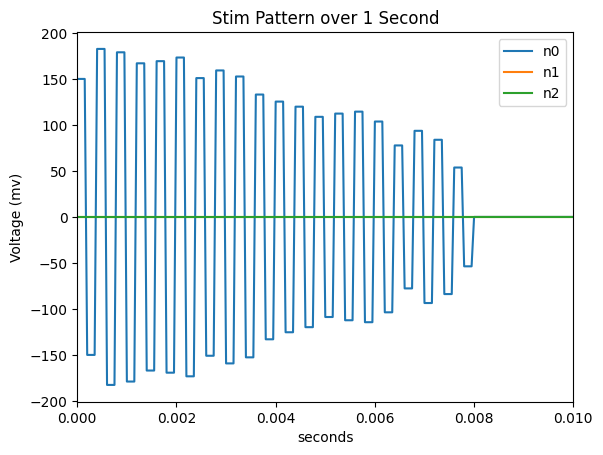

In [11]:
plt.plot(t,signal.T)
plt.legend(['n0','n1','n2'])
plt.xlabel('seconds')
plt.ylabel('Voltage (mv)')
plt.title("Stim Pattern over 1 Second")
plt.xlim(0,.01)
plt.show()

# Group 3

In [14]:
stim_list = [('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('stim', [0, 1], 70, 100), ('delay', 249), ('delay', 5000), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('stim', [0, 1], 70, 100), ('delay', 333), ('delay', 5000), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('stim', [0, 1], 70, 100), ('delay', 499), ('delay', 5000), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('stim', [0, 1], 70, 100), ('delay', 999), ('delay', 5000), ('delay', 5000), ('next', None)]


In [15]:
stim_list.pop()

('next', None)

In [ ]:
signal,t = create_stim_pulse_sequence( stim_list, freq_Hz=20 )